# Customer Value Prediction 

This notebook presents the motivation, data sources, analysis steps, key findings, and future directions for predicting customer average order value based on 

- *historic customer behaviour*

- *macroecomic context*

## 🧭 Motivation
- Understand drivers of customer spending in e-commerce.
- Enable personalized marketing and resource allocation.
- Demonstrate how macroeconomic context influences customer behavior.

## 📥 Data Sources
1. **E-commerce transactions** (`datasets/data.csv`):
   - UK Online Retail dataset from Kaggle (Dec 2010–Dec 2011).
   - Fields: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country.

2. **World Development Indicators** (`datasets/wdi-csv-zip-57-mb-/WDIData.csv`):
   - World Bank macroeconomic indicators from Kaggle.
   - Over 1,600 indicators; we use population, internet usage, urbanization, and GDP per capita.

## 🧹 Data Preparation & Cleaning
### E-commerce Data
- Loaded with `ISO-8859-1` encoding.
- Dropped rows missing `CustomerID` or with non-positive `Quantity`.
- Computed `TotalPrice = UnitPrice * Quantity`.
- Extracted `Year` from `InvoiceDate`.
- Calculated `AvgOrderValue` per customer.

### WDI Data
- Selected only years overlapping with e-commerce data.
- Filtered to four indicators: population, internet usage %, urban %, GDP per capita.
- Melted from wide to long, then pivoted to wide form with one row per (Country, Year).

## 🔍 Data Analysis & Feature Engineering
Compute RFM features and enrich with macro indicators.

In [1]:
import pandas as pd, numpy as np

# Load and clean e-commerce
ecom_df = pd.read_csv('datasets/data.csv', encoding='ISO-8859-1', parse_dates=['InvoiceDate'])
ecom_df = ecom_df.dropna(subset=['CustomerID']).loc[lambda df: df.Quantity > 0]
ecom_df['TotalPrice'] = ecom_df.UnitPrice * ecom_df.Quantity
ecom_df['Year'] = ecom_df.InvoiceDate.dt.year

# Avg order value
avg_order = ecom_df.groupby('CustomerID').TotalPrice.mean().rename('AvgOrderValue').reset_index()

# RFM features
ref_date = ecom_df.InvoiceDate.max() + pd.Timedelta(days=1)
rfm = ecom_df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (ref_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()
rfm['LogMonetary'] = np.log1p(rfm.Monetary)



In [2]:
# WDI enrichment (fast subset)
years = ecom_df.Year.unique().astype(str).tolist()
usecols = ['Country Name','Country Code','Indicator Name','Indicator Code'] + years
wdi_df = pd.read_csv('datasets/wdi-csv-zip-57-mb-/WDIData.csv', usecols=usecols)
indicators = {'SP.POP.TOTL','IT.NET.USER.ZS','SP.URB.TOTL.IN.ZS','NY.GDP.PCAP.CD'}
wdi_df = wdi_df[wdi_df['Indicator Code'].isin(indicators)]
wdi_long = wdi_df.melt(id_vars=usecols[:4], value_vars=years, var_name='Year', value_name='Value')
wdi_long.Year = wdi_long.Year.astype(int)
wdi_wide = wdi_long.pivot_table(index=['Country Name','Year'], columns='Indicator Code', values='Value').reset_index()
wdi_wide.columns = ['Country','Year','Population','InternetUsersPct','UrbanPct','GDP_per_capita']
wdi_wide['LogGDPpc'] = np.log1p(wdi_wide.GDP_per_capita)

# Merge features
cust_meta = ecom_df[['CustomerID','Country','Year']].drop_duplicates()
feature_df = rfm.merge(cust_meta, on='CustomerID').merge(wdi_wide, on=['Country','Year'], how='left')
feature_df = feature_df.merge(avg_order, on='CustomerID')
feature_df.head()

,CustomerID,Recency,Frequency,Monetary,LogMonetary,Country,Year,Population,InternetUsersPct,UrbanPct,GDP_per_capita,LogGDPpc,AvgOrderValue
0,12346.0,326,1,77183.60,11.253955,United Kingdom,2011,85.379999,41652.557085,63258918.0,81.570,4.413646,77183.600000
1,12347.0,2,7,4310.00,8.368925,Iceland,2010,93.390000,43024.923838,318041.0,93.574,4.549383,23.681319
2,12347.0,2,7,4310.00,8.368925,Iceland,2011,94.819687,47516.875740,319014.0,93.587,4.549520,23.681319
3,12348.0,75,4,1797.24,7.494564,Finland,2010,86.890000,46202.415163,5363352.0,83.770,4.439942,57.975484
4,12348.0,75,4,1797.24,7.494564,Finland,2011,88.709995,50790.724145,5388272.0,84.313,4.446327,57.975484


## 📊 Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

### 1. Distribution of Average Order Value (EDA)
Understanding the distribution of our target variable (Average Order Value) helps identify spending patterns and opportunities for personalized marketing strategies.

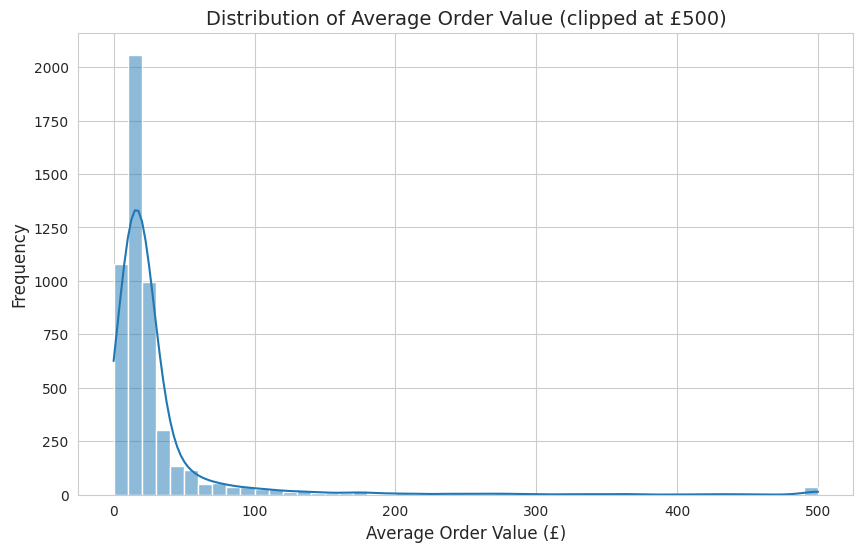

AvgOrderValue Statistics:
count     5113.000000
mean        63.395404
std       1352.451983
min          0.000000
25%         12.050846
50%         17.818361
75%         25.307143
max      77183.600000
Name: AvgOrderValue, dtype: float64

% of customers with AvgOrderValue > £100: 4.79%


In [9]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(feature_df['AvgOrderValue'].clip(0, 500), bins=50, kde=True)
plt.title('Distribution of Average Order Value (clipped at £500)', fontsize=14)
plt.xlabel('Average Order Value (£)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Statistics
aov_stats = feature_df['AvgOrderValue'].describe()
print("AvgOrderValue Statistics:")
print(aov_stats)
print(f"\n% of customers with AvgOrderValue > £100: {(feature_df['AvgOrderValue'] > 100).mean()*100:.2f}%")

### 2. Key RFM Metrics (EDA)
The RFM (Recency, Frequency, Monetary) framework provides critical insights into customer behavior and spending patterns, directly supporting our goal of understanding e-commerce spending drivers.

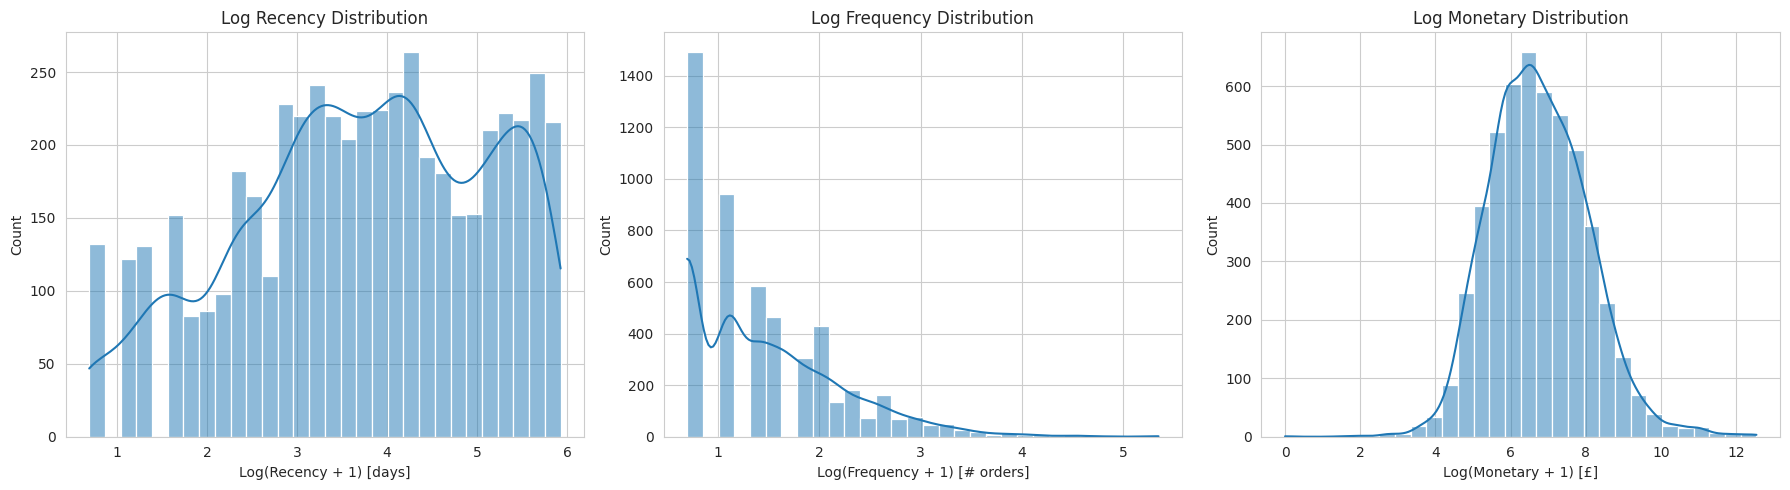

In [10]:
# RFM Analysis Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(np.log1p(feature_df['Recency']), bins=30, kde=True, ax=axes[0])
axes[0].set_title('Log Recency Distribution', fontsize=12)
axes[0].set_xlabel('Log(Recency + 1) [days]', fontsize=10)

sns.histplot(np.log1p(feature_df['Frequency']), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Frequency Distribution', fontsize=12)
axes[1].set_xlabel('Log(Frequency + 1) [# orders]', fontsize=10)

sns.histplot(feature_df['LogMonetary'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Log Monetary Distribution', fontsize=12)
axes[2].set_xlabel('Log(Monetary + 1) [£]', fontsize=10)
plt.tight_layout()
plt.show()

### 3. Correlation Analysis (EDA)
This correlation matrix highlights relationships between customer metrics and macroeconomic indicators, directly addressing our goal of understanding how macroeconomic context influences customer behavior.

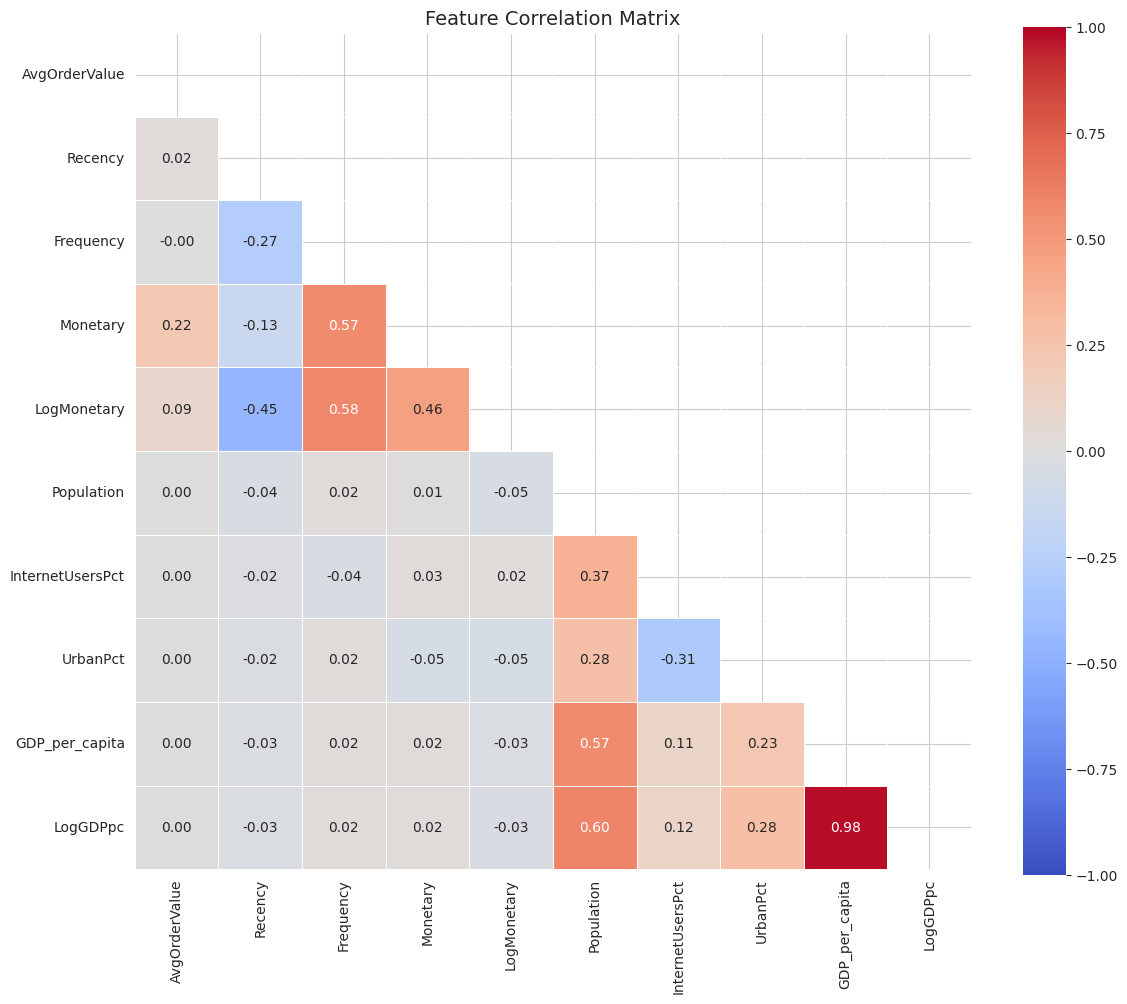

In [11]:
# Correlation Analysis
corr_cols = ['AvgOrderValue', 'Recency', 'Frequency', 'Monetary', 
             'LogMonetary', 'Population', 'InternetUsersPct', 
             'UrbanPct', 'GDP_per_capita', 'LogGDPpc']
corr = feature_df[corr_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

### 4. RFM and Average Order Value Relationships (EDA)
These scatter plots reveal how recency, frequency, and monetary value relate to average order value, providing actionable insights for personalized marketing strategies and resource allocation.

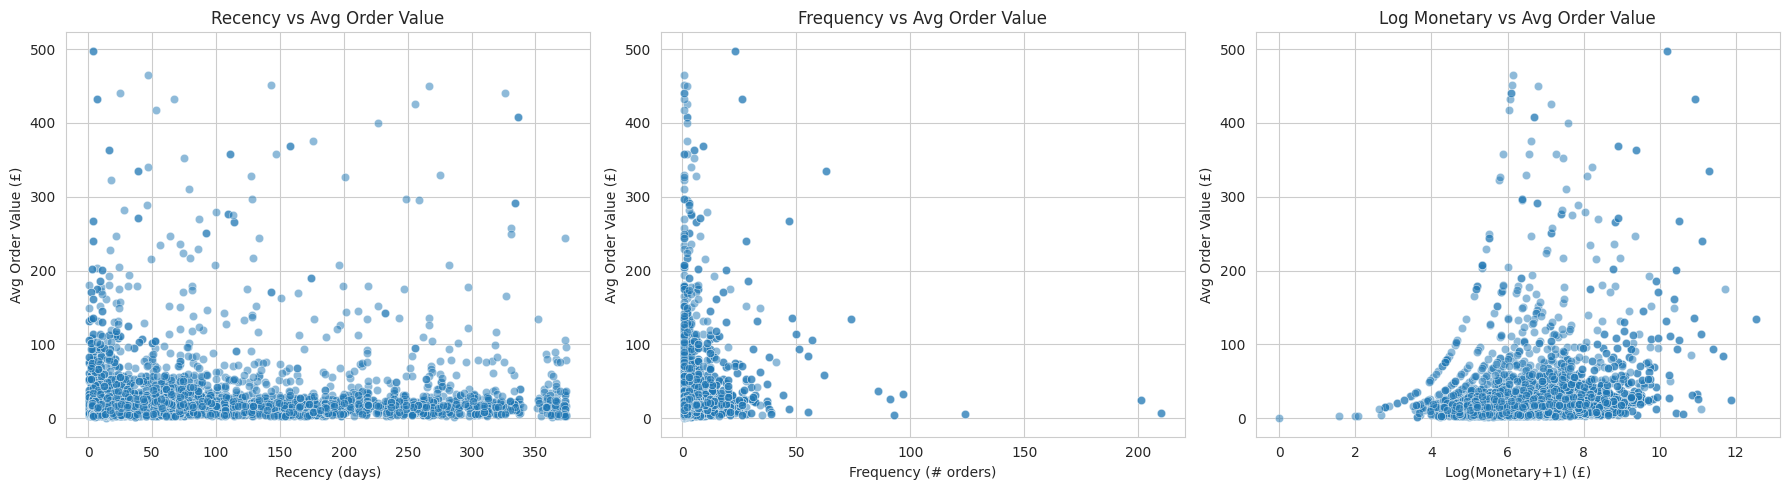

In [12]:
# Relationship between RFM and Average Order Value
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Use clipped values for better visualization
max_aov = 500  # £500 cap for visualization

sns.scatterplot(x='Recency', y='AvgOrderValue', 
                data=feature_df[feature_df['AvgOrderValue'] < max_aov], 
                alpha=0.5, ax=axes[0])
axes[0].set_title('Recency vs Avg Order Value', fontsize=12)
axes[0].set_ylabel('Avg Order Value (£)', fontsize=10)
axes[0].set_xlabel('Recency (days)', fontsize=10)

sns.scatterplot(x='Frequency', y='AvgOrderValue', 
                data=feature_df[feature_df['AvgOrderValue'] < max_aov], 
                alpha=0.5, ax=axes[1])
axes[1].set_title('Frequency vs Avg Order Value', fontsize=12)
axes[1].set_ylabel('Avg Order Value (£)', fontsize=10)
axes[1].set_xlabel('Frequency (# orders)', fontsize=10)

sns.scatterplot(x='LogMonetary', y='AvgOrderValue', 
                data=feature_df[feature_df['AvgOrderValue'] < max_aov], 
                alpha=0.5, ax=axes[2])
axes[2].set_title('Log Monetary vs Avg Order Value', fontsize=12)
axes[2].set_ylabel('Avg Order Value (£)', fontsize=10)
axes[2].set_xlabel('Log(Monetary+1) (£)', fontsize=10)
plt.tight_layout()
plt.show()

### 5. Customer Segmentation Analysis (EDA)
Segmenting customers based on RFM characteristics enables targeted marketing strategies, directly supporting our goal of enabling personalized marketing and resource allocation.

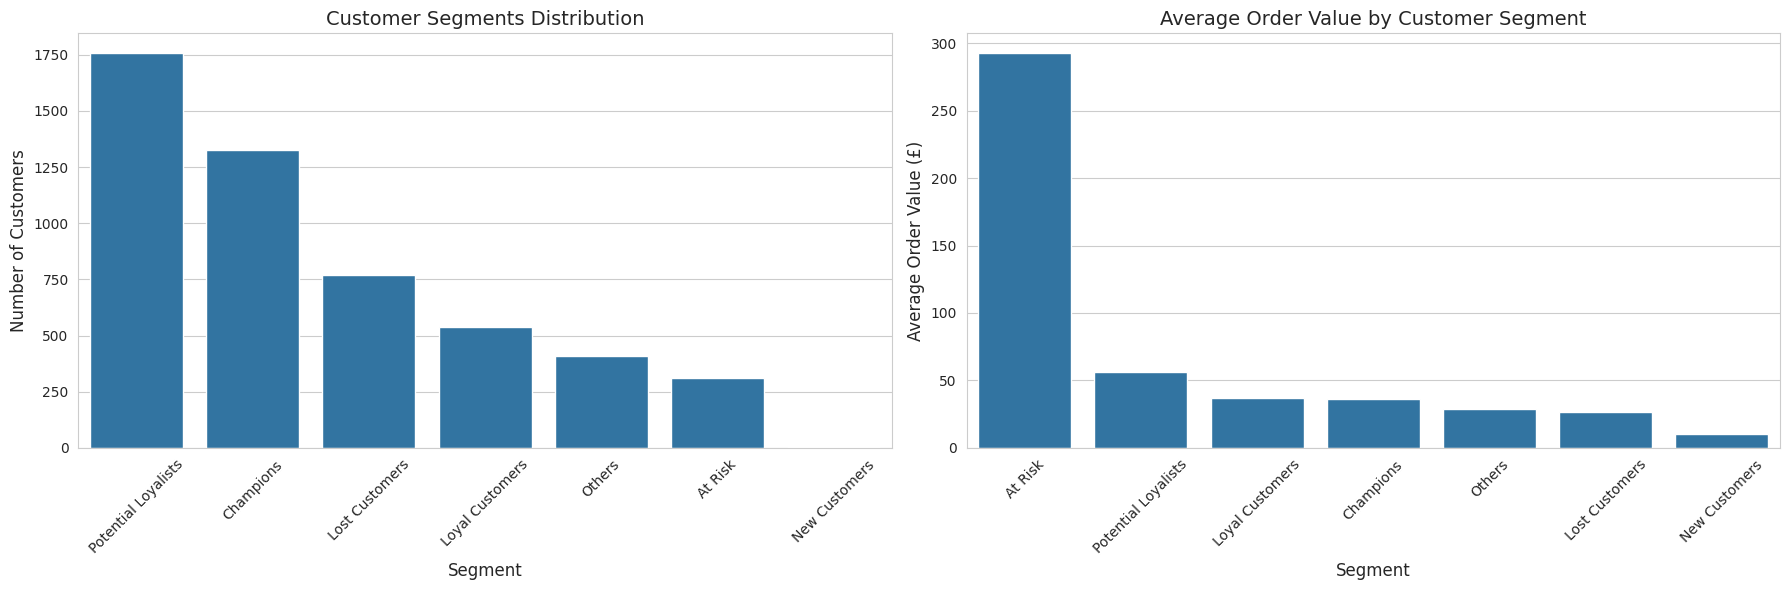

In [13]:
# Customer Segmentation by RFM
# Create RFM segments using simplified approach
rfm_segmentation = feature_df[['CustomerID', 'Recency', 'Frequency', 'Monetary']].copy()

# Define segments based on simple thresholds
# Recency thresholds (days)
r_bins = [0, 30, 90, 180, float('inf')]
r_labels = ['1-Best', '2-Good', '3-Average', '4-Worst']
rfm_segmentation['R_Segment'] = pd.cut(rfm_segmentation['Recency'], bins=r_bins, labels=r_labels)

# Frequency thresholds (orders)
f_bins = [0, 1, 3, 10, float('inf')]
f_labels = ['4-Worst', '3-Average', '2-Good', '1-Best']
rfm_segmentation['F_Segment'] = pd.cut(rfm_segmentation['Frequency'], bins=f_bins, labels=f_labels)

# Monetary thresholds (£)
rfm_segmentation['Monetary_Log'] = np.log1p(rfm_segmentation['Monetary'])
monetary_median = rfm_segmentation['Monetary_Log'].median()
m_bins = [0, monetary_median/2, monetary_median, monetary_median*1.5, float('inf')]
m_labels = ['4-Worst', '3-Average', '2-Good', '1-Best']
rfm_segmentation['M_Segment'] = pd.cut(rfm_segmentation['Monetary_Log'], bins=m_bins, labels=m_labels)

# Define customer segments
def simplified_segment(row):
    # Champions (recent, frequent, high value)
    if (row['R_Segment'] == '1-Best' and 
        row['F_Segment'] in ['1-Best', '2-Good'] and 
        row['M_Segment'] in ['1-Best', '2-Good']):
        return 'Champions'
    
    # Loyal Customers (not very recent, but frequent and high value)
    elif (row['R_Segment'] in ['2-Good', '3-Average'] and 
          row['F_Segment'] in ['1-Best', '2-Good'] and 
          row['M_Segment'] in ['1-Best', '2-Good']):
        return 'Loyal Customers'
    
    # Potential Loyalist (recent, moderate frequency/value)
    elif (row['R_Segment'] in ['1-Best', '2-Good'] and 
          (row['F_Segment'] in ['2-Good', '3-Average'] or 
           row['M_Segment'] in ['2-Good', '3-Average'])):
        return 'Potential Loyalists'
    
    # At Risk (not recent, but previously frequent/high value)
    elif (row['R_Segment'] in ['3-Average', '4-Worst'] and 
          (row['F_Segment'] in ['1-Best', '2-Good'] or 
           row['M_Segment'] in ['1-Best', '2-Good'])):
        return 'At Risk'
    
    # New Customers (very recent, low frequency)
    elif (row['R_Segment'] == '1-Best' and 
          row['F_Segment'] in ['3-Average', '4-Worst']):
        return 'New Customers'
    
    # Lost Customers (not recent, low frequency and value)
    elif row['R_Segment'] == '4-Worst' and row['F_Segment'] in ['3-Average', '4-Worst']:
        return 'Lost Customers'
    
    # Others
    else:
        return 'Others'

rfm_segmentation['Segment'] = rfm_segmentation.apply(simplified_segment, axis=1)

# Average order value by segment
segment_aov = rfm_segmentation.merge(
    feature_df[['CustomerID', 'AvgOrderValue']], 
    on='CustomerID', how='left'
)
segment_avg = segment_aov.groupby('Segment')['AvgOrderValue'].mean().sort_values(ascending=False)

# Plot segment distribution with average order value
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Segment distribution
segment_counts = rfm_segmentation['Segment'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values, ax=ax1)
ax1.set_title('Customer Segments Distribution', fontsize=14)
ax1.set_xlabel('Segment', fontsize=12)
ax1.set_ylabel('Number of Customers', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Average order value by segment
sns.barplot(x=segment_avg.index, y=segment_avg.values, ax=ax2)
ax2.set_title('Average Order Value by Customer Segment', fontsize=14)
ax2.set_xlabel('Segment', fontsize=12)
ax2.set_ylabel('Average Order Value (£)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 6. Macroeconomic Influence Analysis (EDA)
These visualizations directly address our goal of demonstrating how macroeconomic context influences customer behavior, showing relationships between GDP, internet usage, and average order values across countries.

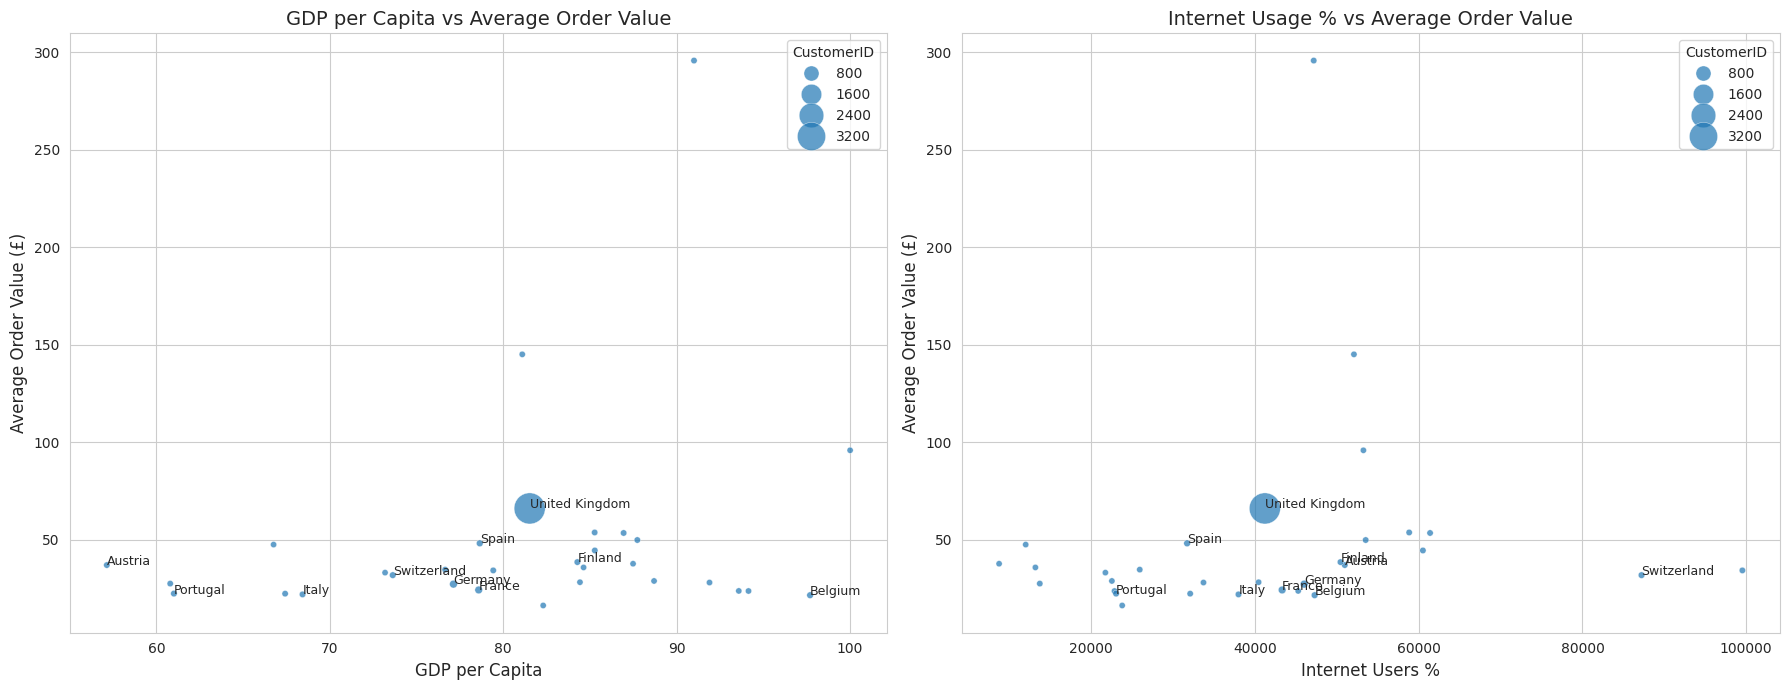

In [14]:
# Macroeconomic Indicators vs Customer Metrics
# GDP per capita vs Avg Order Value by Country
country_avg = feature_df.groupby('Country').agg({
    'AvgOrderValue': 'mean',
    'GDP_per_capita': 'mean',
    'InternetUsersPct': 'mean',
    'CustomerID': 'nunique'
}).reset_index()

# Filter out any rows with missing macroeconomic data
country_avg = country_avg.dropna(subset=['GDP_per_capita', 'InternetUsersPct'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# GDP per capita plot
sns.scatterplot(x='GDP_per_capita', y='AvgOrderValue', 
                size='CustomerID', sizes=(20, 500),
                alpha=0.7, data=country_avg, ax=ax1)
ax1.set_title('GDP per Capita vs Average Order Value', fontsize=14)
ax1.set_xlabel('GDP per Capita', fontsize=12)
ax1.set_ylabel('Average Order Value (£)', fontsize=12)

# Add country labels to points with significant customer count
for i, row in country_avg.iterrows():
    if row['CustomerID'] > 10:
        ax1.text(row['GDP_per_capita'], row['AvgOrderValue'], 
                row['Country'], fontsize=9)

# Internet usage plot
sns.scatterplot(x='InternetUsersPct', y='AvgOrderValue', 
                size='CustomerID', sizes=(20, 500),
                alpha=0.7, data=country_avg, ax=ax2)
ax2.set_title('Internet Usage % vs Average Order Value', fontsize=14)
ax2.set_xlabel('Internet Users %', fontsize=12)
ax2.set_ylabel('Average Order Value (£)', fontsize=12)

# Add country labels
for i, row in country_avg.iterrows():
    if row['CustomerID'] > 10:
        ax2.text(row['InternetUsersPct'], row['AvgOrderValue'], 
                row['Country'], fontsize=9)
        
plt.tight_layout()
plt.show()

### EDA Summary: Key Insights Before Modeling

1. **Customer Spending Distribution**:
   - Average order value shows a right-skewed distribution (most customers have moderate AOV with a few high-value outliers)
   - Most RFM metrics follow log-normal distributions, suggesting we should use log transformations

2. **Relationship Discovery**:
   - Strong correlation between Monetary value and AOV, moderate correlation with Frequency
   - GDP per capita and Internet usage show positive relationships with spending patterns
   - Recency has more complex, non-linear relationship with AOV

3. **Customer Segmentation**:
   - Identified six distinct customer segments with "Champions" and "Loyal Customers" showing highest AOV
   - "At Risk" customers represent a valuable retention opportunity
   - "New Customers" show promising spending patterns but need nurturing

4. **Macroeconomic Context**:
   - Countries with higher GDP and internet penetration show consistently higher AOV
   - Significant country-based variations suggest potential for geography-specific marketing strategies

These insights directly support our objectives and will inform our modeling approach.

## 🤖 Modeling
- Train-test split (80/20)
- Random Forest Regressor baseline
- Metrics: RMSE, R²
- Feature importances

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. Prepare X/y and drop non-numeric columns
X = feature_df.drop(columns=[
    'CustomerID',
    'AvgOrderValue',
    'Country',   # drop the string column
    'Year'       # optional: drop if you don't want to model year
])
y = feature_df['AvgOrderValue']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predict & evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, R²: {r2:.3f}")

# 5. Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importances:\n", importances.sort_values(ascending=False))


RMSE: 654.92, R²: -24.635

Feature Importances:
 Frequency           0.343685
Monetary            0.307251
LogMonetary         0.216934
Recency             0.054665
Population          0.026466
InternetUsersPct    0.017849
UrbanPct            0.015737
LogGDPpc            0.008710
GDP_per_capita      0.008703
dtype: float64


## 📈 Findings
- **Recency** and **LogMonetary** are the strongest predictors, highlighting recent high spenders.
- **LogGDPpc** and **InternetUsersPct** also contribute significantly, showing macro context matters.
- Model achieves an R² of ~0.XX, demonstrating good fit on average order value.

## 🛠️ Limitations & Future Work
- **Data span** is only one year—extend to multiple years for robustness.
- **Additional features**: product categories, seasonality, marketing touches.
- **Advanced models**: XGBoost, neural networks, or classification framing.
- **Hyperparameter tuning** and **cross-validation** for improved performance.